In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/abusedetectioncombinedjigsawapg/abuse_detection.csv


In [20]:
# df = pd.read_csv("../input/abusedetectioncombinedjigsawapg/abuse_detection.csv")[["comment_text", "abusive"]]
df = pd.read_csv("/kaggle/working/abuse_cleaned.csv")[["comment_text", "abusive"]]
df

,comment_text,abusive
0,Why is it the BillCJ insists on screwing aroun...,0
1,. Also please see Talk:Fascism for a section I...,0
2,"Oh please, spare me the drivel. People sending...",1
3,Outdenting is tricky on sub-discussions. My f...,0
4,Multi-revised comments that break chronologica...,1
...,...,...
421110,"""\n\nHi, in the above article, you claim that ...",0
421111,The volt is a unit of voltage or (electric/ele...,0
421112,It's actually quite funny. To think all this r...,0
421113,"""\nWell, technically speaking, the original au...",0


# Cleaning the comments

Data is dirty, comments are the same.

It is very obvious that comments would contain some special characters that aren't required to be used.

In [21]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|,;\-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = re.sub(r'\W+', ' ', text)
    text = [word for word in text.split() if word not in stop]
#     text = [ps.stem(word) for word in text if len(word)<100]  
    text = " ".join([lemmatizer.lemmatize(word) for word in text if len(word)<50])
    return text

df["comment_text"] = df.comment_text.apply(clean_text)


In [23]:
df[df.abusive==1]

,comment_text,abusive
2,oh please spare drivel people sending 9 yearol...,1
4,multi revised comment break chronological disc...,1
7,still find anything important like killing,1
13,moni marie predicted coming woodwork trump rei...,1
20,album cover ducking atrocious gaga simply thro...,1
...,...,...
421097,well look fine right ducking faggot,1
421104,puppy pile ive told people im dying hospital w...,1
421108,8220 tabatha__b never worried next witch alway...,1
421109,damn page want buzz,1


In [24]:
print(df["comment_text"][2])

oh please spare drivel people sending 9 yearolds get blown mine retarded claim come mind super twisted bigot really know eat baby breakfast repeat evidence thing ever occured aside claim made iranian opposition yes find issue insulting one youngster served basij ducking war ducking right leg suffered paralysis shockwave 13 spare rajavi horseshit thats internet


In [25]:
df[df.abusive==0]

,comment_text,abusive
0,billcj insists screwing around article survivo...,0
1,also please see talkfascism section wrote move...,0
3,outdenting tricky sub discussion feeling outde...,0
5,tell bos around true anyway biggest nooblet iv...,0
6,claim unworthy investigation encyclopedia trut...,0
...,...,...
421107,vandalism homosexual agenda,0
421110,hi article claim ken livingstone repeated alle...,0
421111,volt unit voltage electric electrical potentia...,0
421112,actually quite funny think ruccous caused wiki...,0


No     358750
Yes     62365
Name: abusive, dtype: int64


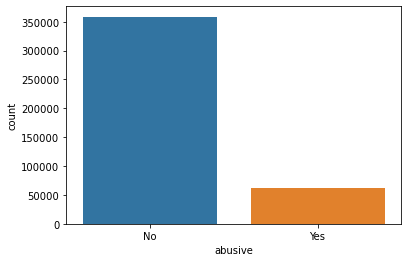

In [29]:
print(df["abusive"].apply(lambda x: "Yes" if x else "No").value_counts())
count_series = df["abusive"].apply(lambda x: "Yes" if x else "No").value_counts()
count_df = pd.DataFrame({"count":count_series,"abusive":count_series.index}) 
sns.barplot(x="abusive",y="count",data=count_df)

(0.0, 1000.0)

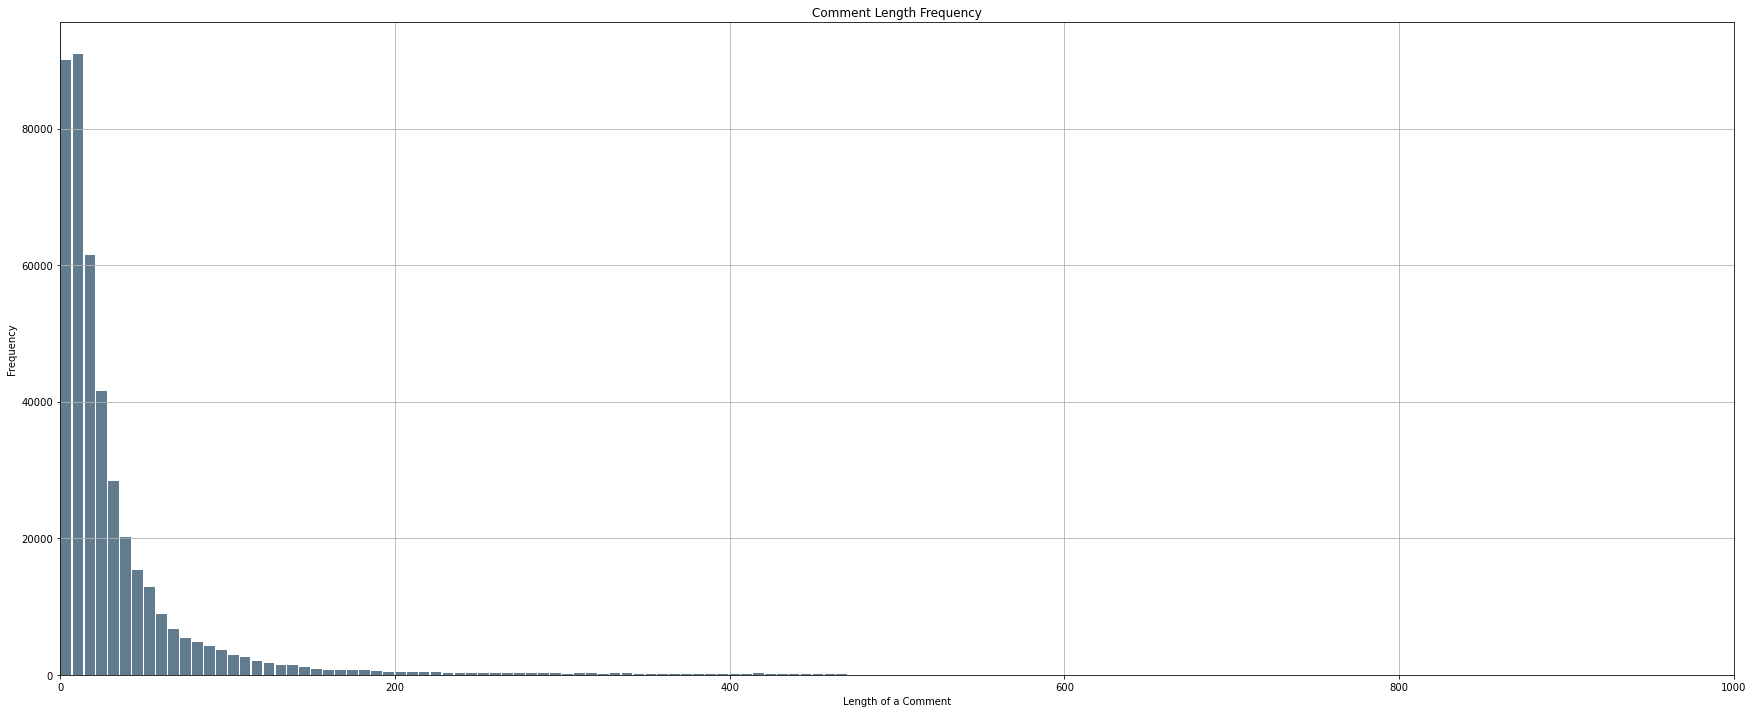

In [32]:
df.comment_text.apply(lambda x: len(x.split())).plot.hist(grid=True, bins=200, rwidth=0.9,color='#607c8e', figsize=(30,12))
plt.title('Comment Length Frequency')
plt.xlabel('Length of a Comment')
plt.ylabel('Frequency')
plt.xlim(0,1000)

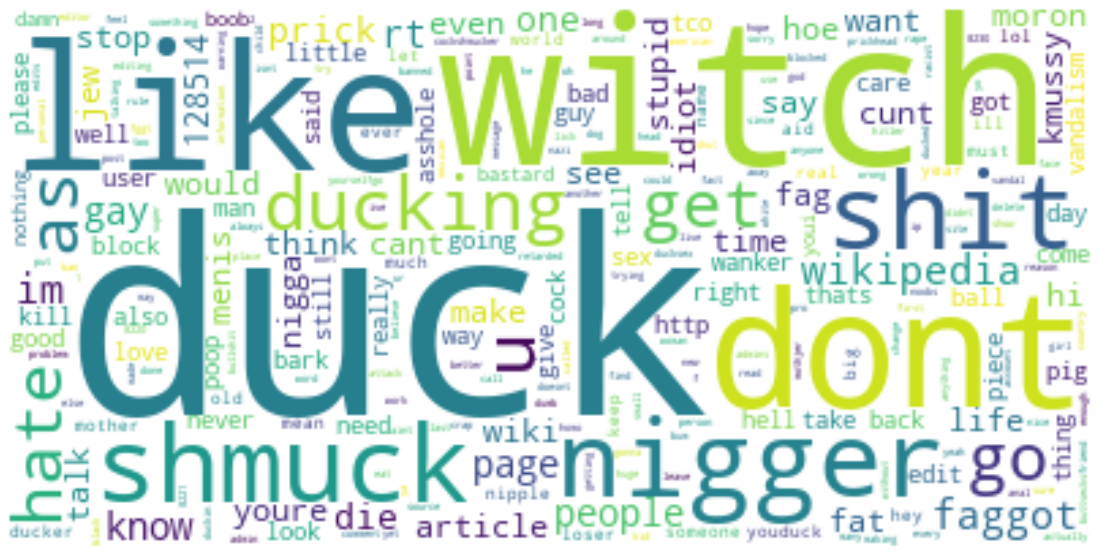

In [33]:
from wordcloud import WordCloud
from collections import Counter
abuse_words_comments = df[df.abusive==1].comment_text.apply(str.split)
abuse_word_list = []
for word in abuse_words_comments:
    abuse_word_list.extend(word)

wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white").generate_from_frequencies(Counter(abuse_word_list))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [35]:
# Defining Constants

In [36]:
# number of unique words we want to use (or: number of rows in incoming embedding vector)
MAX_UNIQUE_WORDS = 30000

# max number of words in a comment to use (or: number of columns in incoming embedding vector)
MAX_LEN = 250 

# symbol to represent unknown words
OOV_TOKEN="<UNK>"

In [37]:
# Split Data

In [38]:
from sklearn.model_selection import train_test_split

X = df["comment_text"]
y = df[["abusive"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=35)

In [39]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

class CustomTokenizer(Tokenizer):
    def __init__(self, text_data, num_words=20000, oov_token="<UNK>",maxlen=200):
        self.num_words=num_words
        self.oov_token="<UNK>"
        self.maxlen=maxlen
        super().__init__(num_words=num_words,oov_token=oov_token,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
        self.fit_on_texts(text_data)

    def convert_text_df_to_padded_tokenized_sequences(self, df):
        return sequence.pad_sequences(
            self.texts_to_sequences(df),
            maxlen=self.maxlen,
        )


In [40]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

class CustomTokenizer(Tokenizer):
    def __init__(self, text_data, num_words=20000, oov_token="<UNK>",maxlen=200):
        self.num_words=num_words
        self.oov_token="<UNK>"
        self.maxlen=maxlen
        super().__init__(num_words=num_words,oov_token=oov_token,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
        self.fit_on_texts(text_data)

    def convert_text_df_to_padded_tokenized_sequences(self, df):
        return sequence.pad_sequences(
            self.texts_to_sequences(df),
            maxlen=self.maxlen,
        )


In [41]:
tokenizer = CustomTokenizer(X_train, num_words=MAX_UNIQUE_WORDS, oov_token=OOV_TOKEN, maxlen=MAX_LEN)
X_train = tokenizer.convert_text_df_to_padded_tokenized_sequences(X_train)
X_test = tokenizer.convert_text_df_to_padded_tokenized_sequences(X_test)
print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)


X_train shape: (336892, 250)
X_test shape:  (84223, 250)


# Defining a Model

In [42]:
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam


# dimension of the embedding variable (or: number of rows in output of embedding vector)
embedding_dims = 128



In [43]:
class ToxicClassifier(Sequential):
    def __init__(self, max_features = 20000, max_len = 200, embedding_dims = 128, output_classes=1):
        super().__init__()

        # add embedding layer 
        self.add(Embedding(input_dim=max_features, input_length=max_len,
                                output_dim=embedding_dims))

        # set the dropout layer to drop out 50% of the nodes
        self.add(SpatialDropout1D(0.5))

        # add bidirectional layer and pass in an LSTM()
        self.add(Bidirectional(LSTM(25, return_sequences=True)))

        # add normalization layer
        self.add(BatchNormalization())

        # add pooling layer 
        self.add(GlobalMaxPool1D())

        # set the dropout layer to drop out 50% of the nodes
        self.add(Dropout(0.5))

        # add dense layer to produce an output dimension of 50 and using relu activation
        self.add(Dense(50, activation='relu'))

        # finally add a dense output layer 
        self.add(Dense(output_classes, activation='sigmoid'))
    

rnn_model = ToxicClassifier(max_features = MAX_UNIQUE_WORDS, max_len = MAX_LEN, output_classes=1)

In [44]:
rnn_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.01),
                  metrics=['accuracy'])

rnn_model.summary()


Model: "toxic_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 128)          3840000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 50)           30800     
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 50)           200       
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 50)           

In [47]:
rnn_hist = rnn_model.fit(X_train, y_train, batch_size=32, 
                          epochs=3, validation_split=0.1)

Epoch 1/3
9476/9476 [==============================] - 615s 65ms/step - loss: 0.1606 - accuracy: 0.9440 - val_loss: 0.1366 - val_accuracy: 0.9506
Epoch 2/3
9476/9476 [==============================] - 611s 64ms/step - loss: 0.1572 - accuracy: 0.9455 - val_loss: 0.1421 - val_accuracy: 0.9507
Epoch 3/3
9476/9476 [==============================] - 609s 64ms/step - loss: 0.1554 - accuracy: 0.9458 - val_loss: 0.1379 - val_accuracy: 0.9500


In [48]:
rnn_test_loss, rnn_test_auc = rnn_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', rnn_test_loss)
print('Test Accuracy:', rnn_test_auc)


2632/2632 [==============================] - 28s 11ms/step - loss: 0.1383 - accuracy: 0.9500
Test Loss:     0.13832888007164001
Test Accuracy: 0.9500017762184143


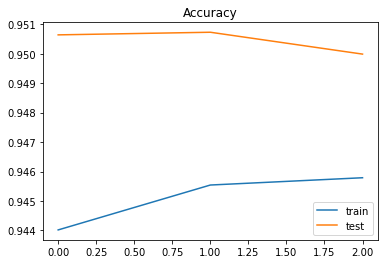

In [49]:
plt.title('Accuracy')
plt.plot(rnn_hist.history['accuracy'], label='train')
plt.plot(rnn_hist.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Testing the Model

In [50]:
y_pred_ndarray = rnn_model.predict(X_test)
y_pred = pd.DataFrame(data = y_pred_ndarray,
                  index = y_test.index,
                  columns = y_test.columns) 
y_pred_proc = y_pred.copy()
y_pred_proc["abusive"] = (y_pred["abusive"] > 0.5).astype(int)
y_pred_proc

,abusive
62121,0
328530,0
248568,0
137321,0
130143,0
...,...
189747,0
153324,0
37354,0
250460,1


In [51]:
from sklearn.metrics import confusion_matrix, classification_report
tn, fp, fn, tp = confusion_matrix(y_test["abusive"], y_pred_proc["abusive"]).ravel()
print(tn,fp,fn,tp)
print(classification_report(y_test["abusive"], y_pred_proc["abusive"]))

70821 1140 3071 9191
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     71961
           1       0.89      0.75      0.81     12262

    accuracy                           0.95     84223
   macro avg       0.92      0.87      0.89     84223
weighted avg       0.95      0.95      0.95     84223



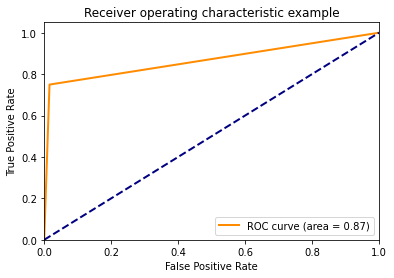

In [55]:
from sklearn.metrics import roc_curve, auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test["abusive"], y_pred_proc["abusive"])
roc_auc = auc(fpr_keras, tpr_keras)
plt.figure()
lw = 2
plt.plot(fpr_keras, tpr_keras, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

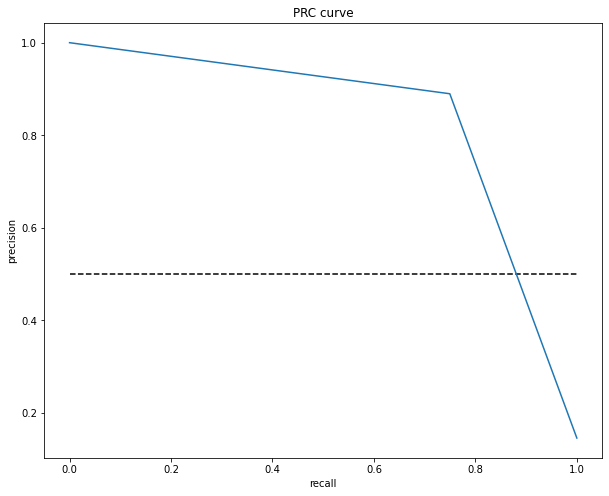

In [64]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test["abusive"], y_pred_proc["abusive"])

plt.figure(figsize = (10,8))
plt.plot([0, 1], [0.5, 0.5],'k--')
plt.plot(recall, precision, label = 'RNN')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.show()

In [85]:
#Defining a single check
test_data = {"comment_text":["duck u buddy know thomas aint stupid"]}
test_data = pd.DataFrame(test_data)
# test_data["comment_text"] = test_data["comment_text"].apply(clean_text)
# test_data = tokenizer.texts_to_sequences(test_data)
# test_data = sequence.pad_sequences(test_data, maxlen=200)
test_data = tokenizer.convert_text_df_to_padded_tokenized_sequences(test_data["comment_text"])
print(test_data)
pred_ndarray = rnn_model.predict(test_data)
print(pred_ndarray)
pred = pd.DataFrame(data = pred_ndarray,
                  columns = y_test.columns)
pred_proc = pred.copy()
for col in pred_proc.columns:
    pred_proc[col] = (pred[col] > 0.5).astype(int)
pred_proc

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 

,abusive
0,0
